# KNN Regressor using Wi-Fi Experiments

<p>Jupyter Notebook which aims to explore the ML algorithm K-Nearest Neighbors as a Regression algorithm using the Wi-Fi technology moreover using the strength of the signal as a basis. </p>

## Imports
Imports of the libraries to be used throughout the experiments

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

## Load File and Structure Data Function
Function to load csv and structure data accordingly

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

## Initialize Training Data

In [3]:
def find_beacon_index():
    first_beacon_index = -1
    for ap in dataset.iloc[:,4:]:
        if ap.islower() == False:
            first_beacon_index = list(dataset).index(ap)
            break
    return first_beacon_index

In [4]:
dataset = load_file('../radiomapBluetoothWiFi.csv')
beacon_index = find_beacon_index()
X_train = dataset.iloc[:,3:beacon_index]
Y_train = dataset.iloc[:,1:3]
nan_filler = X_train.min().min()*1.010
X_train = X_train.replace(0, np.nan)
X_train = X_train.fillna(nan_filler)

## Radio Map Graphical Display

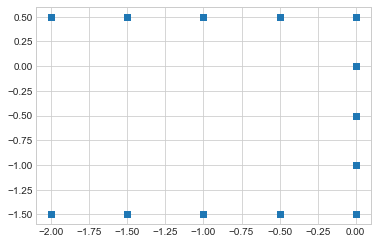

In [5]:
x , y = map(list, zip(*Y_train.values)) 
fig = plt.figure()
ax = plt.axes()
plt.plot(x,y,'s')

## Access Points Graphical Display
Graphical display with the average strength signal transmitted by each access point

<BarContainer object of 12 artists>

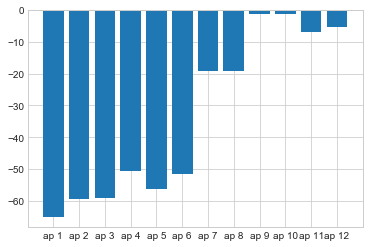

In [6]:
count_aps = {}
counter = 1
for ap in X_train:
    mean_value = dataset[ap].mean()
    count_aps['ap ' + str(counter)] = mean_value
    counter = counter + 1
plt.bar(range(len(count_aps)),list(count_aps.values()),align='center',tick_label=list(count_aps.keys()))

## Number of Fingerprints per Reference Point Graphical Display
Graphical display of the number of fingerprints retrieved at each reference point

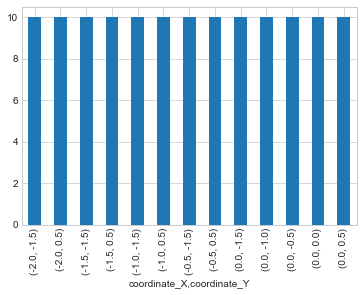

In [7]:
reference_points = dataset.groupby(['coordinate_X','coordinate_Y'])
reference_points.size().plot(kind="bar")

## Signal Strength Distribution Display
Graphical display of the distribution of the signal strength

Text(0, 0.5, 'Probability')

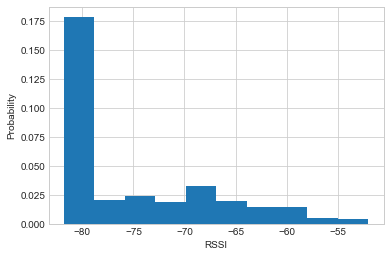

In [8]:
flatten_results = X_train.values.flatten().tolist()
flatten_results = list(filter((0).__ne__,flatten_results))
plt.hist(flatten_results,density=True)
plt.xlabel('RSSI')
plt.ylabel('Probability')

## Initialize KNN Parameters arrays
Initialization of the arrays with the different possible values for the parameters of KNN Regression function

In [9]:
#Knn Configurable parameters arary
distance_metris = ["euclidean", "manhattan", "canberra", "braycurtis"]
algorithms = ["brute","kd_tree","ball_tree","auto"]
filters = ["Median","Mean","No Filter"]
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
weights = ["uniform","distance"]
default_data_scenario = Y_train.copy()
default_data_scenario_groups = default_data_scenario["coordinate_X"].map(str)+","+default_data_scenario["coordinate_Y"].map(str)
#Test data from separate csv file
test_dataset_from_file = load_file('../radiomap_pedro.csv')
X_test_from_file = test_dataset_from_file.iloc[:,3:]
Y_test_from_file = test_dataset_from_file.iloc[:,1:3]
X_test_from_file = X_test_from_file.fillna(nan_filler)

## Statistics Output Format
Structure of the statistical output of each call to the KNN Regression Function

In [10]:
def structure_data(data,rsquared):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    r_squared = rsquared
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue,r_squared]
    return statistical_results

## Configurable KNN Regression Function 
Configurable function to aplpy the knn to a training set

In [11]:
def compute_KNN_with_Regression(trainX_data = None,trainY_data = None,testX_data = None,testY_data = None,scaler = None,cross_validation = None,n_neighbors=5,
                                weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=-1):
    # Init the KNN Regressor Estimator
    knn_regression_estimator = KNeighborsRegressor(n_neighbors,weights,algorithm,leaf_size,p,metric,metric_params,n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,knn_regression_estimator)
    else:
        main_estimator = knn_regression_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_data_scenario_groups)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    # Structure data to statistics
    statistical_array = list()
    coord_cols = ['coordinate_X','coordinate_Y']
    predictions = pd.DataFrame(predict_test,columns=coord_cols)
    result = testY_data.join(predictions, rsuffix="_predicted")
    observed_errors = predictions[coord_cols] - result[coord_cols]
    error = pd.DataFrame(observed_errors.apply(np.linalg.norm, axis=1), columns=["error"])
    result = pd.concat([result,error], axis = 1)
    return structure_data(result,coefficient_determination)

## Experiments

### 1st Experiment - Running KNN function with default parameters and testing data equal to training data

In [12]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_KNN_with_Regression(trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.405791,0.404,0.63561,0.49111,0.0,0.2,0.6,1.381275,0.0,1.788854,0.717246


### 2nd Experiment - Finding the best k parameter with Grid Search

In [13]:
def grid_search():
    skf = StratifiedKFold()
    splited = skf.split(X_train.values,default_data_scenario_groups.values,groups=default_data_scenario_groups)
    knn_regressor_estimator = KNeighborsRegressor() #init knn regressor estimator
    k_range = list(range(1, 31))
    param_grid = {'knn__n_neighbors': k_range}
    # Create a pipeline
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_regressor_estimator)])
    estimator = GridSearchCV(pipe, param_grid,cv=splited,scoring=sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,
                                                        greater_is_better=False,
                                                        multioutput="uniform_average"))
    #fit model to data
    estimator.fit(X_train.values, Y_train.values)
    print(estimator.best_params_)
    return estimator.best_params_['knn__n_neighbors']


In [14]:
best_knn = grid_search()

{'knn__n_neighbors': 2}


### 3rd Experiment - Graphical Display of k accuracy

In [15]:
def find_fit_k():
    skf = StratifiedKFold()
    splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
    knn_regressor_estimator = KNeighborsRegressor() #init knn regressor estimator
    k_range = list(range(1, 31))
    param_grid = {'knn__n_neighbors': k_range}
    # Create a pipeline
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_regressor_estimator)])
    estimator = GridSearchCV(pipe, param_grid,cv=splited,scoring=sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,
                                                        greater_is_better=False,
                                                        multioutput="uniform_average"))
    #fit model to data
    estimator.fit(X_train.values, Y_train.values)
    grid_mean_scores = estimator.cv_results_['mean_test_score']
    print('Max accuracy: ', max(grid_mean_scores))
    plt.plot(k_range, grid_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-validated accuracy')

Max accuracy:  -0.32427884615384617


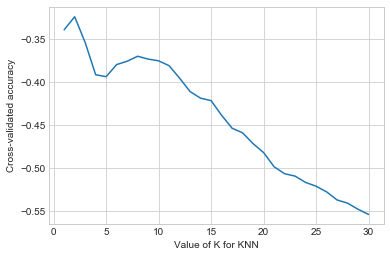

In [16]:
find_fit_k()

### 4th Experiment - Running the KNN function with default parameters and Hold-out Cross Validation

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,test_size
0,0.416993,0.346154,0.588348,0.432003,0.000000,0.300000,0.540000,1.184787,0.000000,1.264911,0.754719,0.1
2,0.647480,0.834103,0.913292,0.652526,0.050000,0.400000,1.042954,1.737216,0.000000,2.039608,0.423672,0.3
1,0.657027,0.856538,0.925494,0.664716,0.000000,0.450000,1.106518,1.801081,0.000000,2.039608,0.398307,0.2
4,0.718294,0.912308,0.955148,0.634472,0.200000,0.447214,1.120503,1.829160,0.000000,2.262742,0.340423,0.5
3,0.726212,1.017500,1.008712,0.706913,0.100000,0.423607,1.170470,1.931973,0.000000,2.262742,0.268345,0.4
5,0.741796,0.813846,0.902134,0.516728,0.300000,0.541548,0.943398,1.708801,0.100000,1.910497,0.411353,0.6
6,0.837128,0.902857,0.950188,0.452017,0.447214,0.800000,1.118034,1.615502,0.200000,1.720465,0.351640,0.7
7,0.891241,0.961635,0.980630,0.411034,0.565685,0.824621,1.004988,1.618487,0.223607,1.886796,0.315436,0.8
8,1.070128,1.301368,1.140775,0.396912,0.854400,1.104536,1.266487,1.655295,0.223607,1.941649,0.074826,0.9


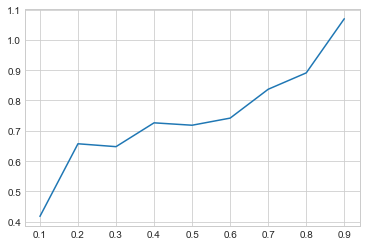

In [17]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train,Y_train, test_size = size, random_state = 6,stratify=default_data_scenario_groups)
    X_train_split = X_train_split.reset_index(drop=True)
    X_test_split = X_test_split.reset_index(drop=True)
    Y_train_split = Y_train_split.reset_index(drop=True)
    Y_test_split = Y_test_split.reset_index(drop=True)
    result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['test_size'],statistics['mae'])

### 5th Experiment - Running the KNN function with default parameters and Stratified K-Fold cross validation

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds
8,0.523574,0.635154,0.796965,0.603177,0.0,0.241421,0.800000,1.697056,0.0,2.039608,0.554638,10
7,0.549123,0.675923,0.822145,0.614239,0.0,0.380278,0.800000,1.698675,0.0,2.022375,0.522140,9
6,0.576189,0.749538,0.865759,0.648677,0.0,0.400000,0.801868,1.837253,0.0,2.262742,0.469933,8
5,0.588352,0.756077,0.869527,0.642726,0.0,0.400000,0.824621,1.814650,0.0,2.262742,0.459520,7
4,0.593322,0.763923,0.874027,0.644271,0.0,0.400000,0.897761,1.888317,0.0,2.262742,0.467768,6
3,0.614981,0.787846,0.887607,0.642511,0.0,0.400000,0.866408,1.886796,0.0,2.262742,0.442017,5
2,0.633790,0.823846,0.907660,0.652249,0.1,0.400000,0.833555,1.899832,0.0,2.334524,0.412949,4
1,0.719216,1.054923,1.027094,0.736084,0.1,0.504951,0.984886,2.141449,0.0,2.828427,0.246916,3
0,0.740450,1.039231,1.019427,0.703400,0.2,0.447214,1.023110,2.121320,0.0,2.828427,0.245147,2


Number of Folds:  10


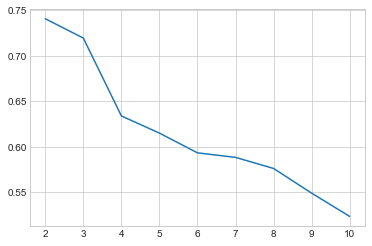

In [18]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(2,11)
results = list()
for cv in cross_validation_list:
    skf = StratifiedKFold(n_splits=cv)
    splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
    result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)  
    result.append(cv)
    results.append(result)
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

### 6th Experiment -  Running the KNN function with default parameters and Leave One Group Out cross validation

In [19]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
loo = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,1.16741,1.750615,1.323108,0.62512,0.655234,1.090785,1.498555,2.126029,0.141421,2.828427,-0.24441


### 7th Experiment - Compare cross validation methods

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,method
2,0.523574,0.635154,0.796965,0.603177,0.000000,0.241421,0.800000,1.697056,0.000000,2.039608,0.554638,Stratified K-Fold
1,0.647480,0.834103,0.913292,0.652526,0.050000,0.400000,1.042954,1.737216,0.000000,2.039608,0.423672,HoldOut
0,1.167410,1.750615,1.323108,0.625120,0.655234,1.090785,1.498555,2.126029,0.141421,2.828427,-0.244410,LOO


Selected cross validation method:  Stratified K-Fold


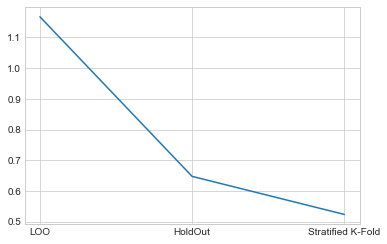

In [20]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method']
results = list()
X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train,Y_train, test_size = 0.3, random_state = 6,stratify=Y_train)
X_train_split = X_train_split.reset_index(drop=True)
X_test_split = X_test_split.reset_index(drop=True)
Y_train_split = Y_train_split.reset_index(drop=True)
Y_test_split = Y_test_split.reset_index(drop=True)
holdout = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler())
loo.append('LOO')
results.append(loo)
holdout.append('HoldOut')
results.append(holdout)
skf = StratifiedKFold(n_splits=selected_fold)
splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
skfold = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)
skfold.append('Stratified K-Fold')
results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'])
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

### 8th Experiment - Running the KNN function with the different weights

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,weights
0,0.523574,0.635154,0.796965,0.603177,0.0,0.241421,0.8,1.697056,0.0,2.039608,0.554638,uniform
1,0.523574,0.635154,0.796965,0.603177,0.0,0.241421,0.8,1.697056,0.0,2.039608,0.554638,distance


Selected weight:  uniform


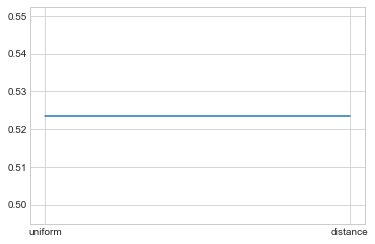

In [21]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','weights']
results = list()
for weight in weights:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                           weights = weight)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)
    else:
        result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                           weights = weight)
    result.append(weight)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['weights'],statistics['mae'])
selected_weight = statistics.sort_values(by=['mae'])['weights'].head(1).values[0]
print("Selected weight: ",selected_weight)

### 9th Experiment - Running the KNN function with the different preprocessing methods

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,preprocessing,preprocessingFunc
1,0.488274,0.544615,0.737981,0.555498,0.0,0.300000,0.664552,1.606848,0.0,1.843909,0.615387,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))"
0,0.523574,0.635154,0.796965,0.603177,0.0,0.241421,0.800000,1.697056,0.0,2.039608,0.554638,StandardScaler,"StandardScaler(copy=True, with_mean=True, with..."
3,0.533330,0.653385,0.808322,0.609758,0.0,0.250000,0.746645,1.882606,0.0,2.080865,0.539899,None,None
2,0.534135,0.655462,0.809606,0.610763,0.0,0.250000,0.746645,1.882606,0.0,2.080865,0.538052,MaxAbsScaler,MaxAbsScaler(copy=True)


Selected Preprocessing:  MinMaxScaler


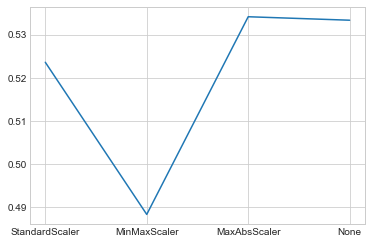

In [22]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','preprocessing','preprocessingFunc']
results = list()
for preprocess in scaler:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = splited)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = splited)
    else:
        result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=preprocess)
    if(preprocess is None):
        regex = 'None'
    else:
        regex = re.search('(\w+)\(',str(preprocess)).group(1)
    result.append(regex)
    result.append(preprocess)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

### 10th Experiment - Running the KNN function with the different algorithms

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,algorithms
1,0.523574,0.635154,0.796965,0.603177,0.0,0.241421,0.8,1.697056,0.0,2.039608,0.554638,kd_tree
2,0.523574,0.635154,0.796965,0.603177,0.0,0.241421,0.8,1.697056,0.0,2.039608,0.554638,ball_tree
3,0.523574,0.635154,0.796965,0.603177,0.0,0.241421,0.8,1.697056,0.0,2.039608,0.554638,auto
0,0.526261,0.643077,0.801921,0.607425,0.0,0.241421,0.8,1.697056,0.0,2.039608,0.549921,brute


Selected Algorithm:  kd_tree


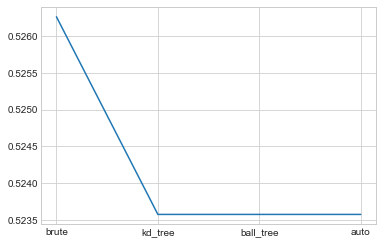

In [23]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','algorithms']
results = list()
for algorithm in algorithms:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            algorithm = algorithm)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            algorithm = algorithm)
    else:
        result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            algorithm = algorithm)
    result.append(algorithm)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['algorithms'],statistics['mae'])
selected_algorithm = statistics.sort_values(by=['mae'])['algorithms'].head(1).values[0]
print("Selected Algorithm: ",selected_algorithm)

### 11th Experiment - Running the KNN function with the different distance metrics

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,distance
2,0.311036,0.305769,0.552964,0.458962,0.0,0.000000,0.412311,1.307112,0.0,2.002498,0.781404,canberra
1,0.397516,0.424462,0.651507,0.518177,0.0,0.170711,0.600000,1.500000,0.0,1.788854,0.697756,manhattan
3,0.407261,0.467538,0.683768,0.551376,0.0,0.100000,0.530000,1.606848,0.0,2.009975,0.662144,braycurtis
0,0.523574,0.635154,0.796965,0.603177,0.0,0.241421,0.800000,1.697056,0.0,2.039608,0.554638,euclidean


Selected Distance Metric:  canberra


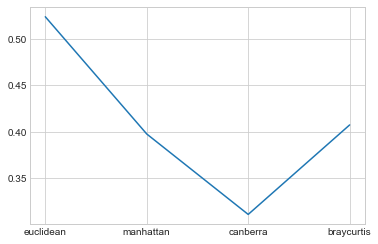

In [24]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','distance']
results = list()
for distance in distance_metris:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            metric = distance)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            metric = distance)
    else:
        result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            metric = distance)
    result.append(distance)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['distance'],statistics['mae'])
selected_distance_metric = statistics.sort_values(by=['mae'])['distance'].head(1).values[0]
print("Selected Distance Metric: ",selected_distance_metric)

### 12th Experiment: Run with every configurable parameters and let the program decide the best parameters
Match these with the previously settled.

In [25]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','distance','preprocessing','weights']
results = list()
k_range = range(1, 31)
for distance in distance_metris:
    for preprocessing in scaler:
        for weight in weights:
            if selected_method == 'LOO':
                cv = LeaveOneGroupOut()
                splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
                result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocessing,cross_validation = splited,
                                                    metric = distance,weights=weight)  
            elif selected_method =='Stratified K-Fold':
                skf = StratifiedKFold(n_splits=selected_fold)
                splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
                result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocessing,cross_validation = splited,
                                                    metric = distance,weights=weight)
            else:
                result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=preprocessing,
                                                    metric = distance,weights=weight)
            result.append(distance)
            if(preprocessing is None):
                regex = 'None'
            else:
                regex = re.search('(\w+)\(',str(preprocessing)).group(1)
            result.append(regex)
            result.append(weight)
            results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,distance,preprocessing,weights
17,0.274007,0.267301,0.517011,0.440126,0.000000e+00,2.220446e-16,0.353144,1.190998,0.0,2.001985,0.810881,canberra,StandardScaler,distance
25,0.290971,0.299195,0.546988,0.464967,0.000000e+00,3.330669e-16,0.283108,1.345427,0.0,2.007054,0.787609,braycurtis,StandardScaler,distance
27,0.295470,0.297153,0.545117,0.459866,0.000000e+00,5.251130e-02,0.245082,1.302963,0.0,1.788854,0.790880,braycurtis,MinMaxScaler,distance
9,0.296629,0.298261,0.546133,0.460329,0.000000e+00,2.220446e-16,0.241378,1.348977,0.0,1.788854,0.790845,manhattan,StandardScaler,distance
11,0.298510,0.300123,0.547835,0.461141,0.000000e+00,1.175544e-02,0.267179,1.287677,0.0,1.788854,0.789488,manhattan,MinMaxScaler,distance
16,0.311036,0.305769,0.552964,0.458962,0.000000e+00,0.000000e+00,0.412311,1.307112,0.0,2.002498,0.781404,canberra,StandardScaler,uniform
21,0.311791,0.330448,0.574846,0.484812,0.000000e+00,5.003370e-02,0.258768,1.397947,0.0,2.000000,0.767125,canberra,MaxAbsScaler,distance
23,0.311791,0.330448,0.574846,0.484812,0.000000e+00,5.003370e-02,0.258768,1.397947,0.0,2.000000,0.767125,canberra,None,distance
13,0.314233,0.314208,0.560542,0.465978,0.000000e+00,9.997934e-02,0.278203,1.375314,0.0,1.788854,0.778788,manhattan,MaxAbsScaler,distance
15,0.315134,0.315068,0.561309,0.466295,0.000000e+00,9.997934e-02,0.285528,1.375314,0.0,1.788854,0.777855,manhattan,None,distance


### 13th Experiment: Running the KNN function with data filtered 

In [28]:
def apply_filter():
    statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','filter']
    results = list()
    for filterelement in filters:
        if filterelement == 'Median':
            result = apply_median_filter()
        elif filterelement == 'Mean':
            result = apply_mean_filter()
        else:
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
            result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),metric = selected_distance_metric,
                                                 cross_validation = splited,
                                                 weights=selected_weight)
            result.append('No Filter')
        results.append(result)
    statistics = pd.DataFrame(columns=statistical_cols,data=results)
    display(statistics.sort_values(by=['mae']))
    plt.plot(statistics['filter'],statistics['mae'])
    selected_filter = statistics.sort_values(by=['mae'])['filter'].head(1).values[0]
    print("Selected Filter: ",selected_filter)
    return selected_filter
            

def apply_median_filter():
    medians = list()
    aps = ['coordinate_X','coordinate_Y']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        x = rp[0]
        y = rp[1]
        medians_list = [x,y]
        for ap in X_train:
            median = access_points[ap].median()
            medians_list.append(median)
        medians.append(medians_list)
    median_pd = pd.DataFrame(medians,columns = aps)
    x_train = median_pd.iloc[:,2:]
    y_train = median_pd.iloc[:,:2]
    x_train = x_train.fillna(nan_filler)
    result = compute_KNN_with_Regression(trainX_data=x_train,trainY_data=y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),metric = selected_distance_metric,weights=selected_weight)
    result.append('Median')
    return result

def apply_mean_filter(): 
    means = list()
    aps = ['coordinate_X','coordinate_Y']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        x = rp[0]
        y = rp[1]
        means_list = [x,y]
        for ap in X_train:
            mean = access_points[ap].mean()
            means_list.append(mean)
        means.append(means_list)
    mean_pd = pd.DataFrame(means,columns = aps)
    x_train = mean_pd.iloc[:,2:]
    y_train = mean_pd.iloc[:,:2]
    x_train = x_train.fillna(nan_filler)
    result = compute_KNN_with_Regression(trainX_data=x_train,trainY_data=y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),metric = selected_distance_metric,weights=selected_weight)
    result.append('Mean')
    return result

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,filter
2,0.311036,0.305769,0.552964,0.458962,0.000000,0.000000,0.412311,1.307112,0.000000,2.002498,0.781404,No Filter
0,1.138200,1.340154,1.157650,0.212136,0.948683,1.053523,1.341641,1.500000,0.707107,1.500000,0.008687,Median
1,1.192345,1.473769,1.213989,0.229100,1.000000,1.204159,1.303840,1.500000,0.608276,1.627882,-0.088027,Mean


Selected Filter:  No Filter


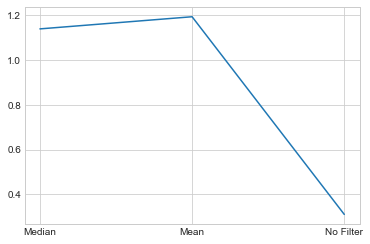

In [29]:
selected_filter = apply_filter()

## Results Analysis and Conclusion
Analysis of the outcomes of the different experiments and final conclusions.

In [30]:
conclusion_cols=['K Parameter','Cross Validation','Weight','Preprocessing','Algorithm','Distance','Filtering']
conclusion_list = [best_knn,selected_method,selected_weight,selected_preprocessing,selected_algorithm,selected_distance_metric,selected_filter]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)
statistical_cols_csv = conclusion_cols
statistical_cols_csv.append('Experimentation')
result_csv = conclusion_list
result_csv.append('KNN Regressor Wifi')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../parameters_results.csv',mode='a',index=False,header=False)

,K Parameter,Cross Validation,Weight,Preprocessing,Algorithm,Distance,Filtering
0,2,Stratified K-Fold,uniform,MinMaxScaler,kd_tree,canberra,No Filter


### Best Result

In [32]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
if selected_method == 'LOO':
    cv = LeaveOneGroupOut()
    splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
    result = compute_KNN_with_Regression(n_neighbors=best_knn,testX_data=X_train,testY_data=Y_train,scaler=selected_preprocesssing_func,cross_validation = splited,
                            metric = selected_distance_metric,weights=selected_weight)  
elif selected_method =='Stratified K-Fold':
    skf = StratifiedKFold(n_splits=selected_fold)
    splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
    result = compute_KNN_with_Regression(n_neighbors=best_knn,testX_data=X_train,testY_data=Y_train,scaler=selected_preprocesssing_func,cross_validation = splited,
                            metric = selected_distance_metric,weights=selected_weight)  
else:
    result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=selected_preprocesssing_func,
                            metric = selected_distance_metric,weights=selected_weight)
results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('KNN Regressor Wifi')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../tests_results.csv',mode='a',index=False,header=False)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.28735,0.375,0.612372,0.54286,0.0,0.0,0.0,1.25,0.0,2.358495,0.725213


### Best result - using other dataset

In [34]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
default_data_scenario = Y_test_from_file.copy()
default_data_scenario_groups = default_data_scenario["coordinate_X"].map(str)+","+default_data_scenario["coordinate_Y"].map(str)
if selected_method == 'LOO':
    cv = LeaveOneGroupOut()
    splited = cv.split(X_test_from_file,Y_test_from_file,groups=default_data_scenario_groups)
    result = compute_KNN_with_Regression(n_neighbors=best_knn,testX_data=X_test_from_file,testY_data=Y_test_from_file,scaler=selected_preprocesssing_func,cross_validation = splited,
                            metric = selected_distance_metric,weights=selected_weight)  
elif selected_method =='Stratified K-Fold':
    skf = StratifiedKFold(n_splits=selected_fold)
    splited = skf.split(X_test_from_file.values,default_data_scenario_groups,groups=default_data_scenario_groups)
    result = compute_KNN_with_Regression(n_neighbors=best_knn,testX_data=X_test_from_file,testY_data=Y_test_from_file,scaler=selected_preprocesssing_func,cross_validation = splited,
                            metric = selected_distance_metric,weights=selected_weight)  
else:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_test_from_file,Y_test_from_file, test_size = 0.3, random_state = 6,stratify=default_data_scenario_groups)
    X_train_split = X_train_split.reset_index(drop=True)
    X_test_split = X_test_split.reset_index(drop=True)
    y_train_split = y_train_split.reset_index(drop=True)
    y_test_split = y_test_split.reset_index(drop=True)
    result = compute_KNN_with_Regression(n_neighbors=best_knn,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=selected_preprocesssing_func,
                            metric = selected_distance_metric,weights=selected_weight)
results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.296581,0.73225,0.855716,0.803078,0.0,0.0,0.0,2.0,0.0,6.0,0.994844
